In [74]:
import sys
parentdir = 'C:\\Users\\Jerzy\\Documents\\GitHub\\BAMT'
sys.path.insert(0,parentdir) 

In [75]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from preprocess.discretization import discretization, get_nodes_type, code_categories, get_nodes_sign
from visualization.visualization import draw_BN, draw_comparative_hist
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')
import math
from bayesian.calculate_accuracy import calculate_acc
from bayesian.sampling import generate_synthetics
import networkx as nx
from scipy.spatial import distance
from sklearn.cluster import KMeans
import operator
from copy import copy
from sklearn.metrics import accuracy_score, mean_squared_error
from external.libpgm.sampleaggregator import SampleAggregator
from typing import Tuple
from dtaidistance import dtw
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
from graph.precision_recall import precision_recall
from tqdm import tqdm
import time
plt.rcParams.update({'font.size': 22})

In [76]:
def get_n_nearest(data, columns, corr = False, number_close=5):
    groups = []
    if corr:
        for c in columns:
            close_ind = data[c].sort_values(ascending=False).index.tolist()
            groups.append(close_ind[0:number_close+1])
    else:
        for c in columns:
            close_ind = data[c].sort_values().index.tolist()
            groups.append(close_ind[0:number_close+1])

    return groups

In [77]:
df = pd.read_csv('C:\\Users\\Jerzy\\Documents\\GitHub\\BAMT\\data\\hailfinder.csv')
df

,N0_7muVerMo,SubjVertMo,QGVertMotion,CombVerMo,AreaMeso_ALS,SatContMoist,RaoContMoist,CombMoisture,AreaMoDryAir,VISCloudCov,...,MeanRH,MidLLapse,MvmtFeatures,RHRatio,SfcWndShfDis,SynForcng,TempDis,WindAloft,WindFieldMt,WindFieldPln
0,WeakUp,StronUp,Neutral,WeakUp,WeakUp,Wet,VeryWet,VeryWet,VeryWet,PC,...,Average,CloseToDryAd,NoMajor,MoistMDryL,DryLine,LittleChange,None,LV,LVorOther,LV
1,Neutral,Neutral,Down,Neutral,Neutral,VeryWet,Neutral,Wet,Wet,Clear,...,VeryMoist,ModerateOrLe,NoMajor,Other,E_W_N,LittleChange,None,NWQuad,LVorOther,E_NE
2,WeakUp,Neutral,Neutral,WeakUp,WeakUp,VeryWet,Dry,VeryWet,VeryWet,PC,...,Average,ModerateOrLe,OtherRapid,MoistMDryL,DenvCyclone,LittleChange,Moving,SWQuad,Westerly,DenvCyclone
3,Neutral,Down,Neutral,Neutral,Neutral,Wet,Neutral,Neutral,Dry,Cloudy,...,Dry,Steep,NoMajor,MoistMDryL,DryLine,LittleChange,QStationary,LV,LVorOther,DenvCyclone
4,Down,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,PC,...,Average,Steep,StrongFront,Other,None,PosToNeg,None,SWQuad,Westerly,SEQuad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,StrongUp,Down,StrongUp,WeakUp,WeakUp,Neutral,Dry,Dry,Dry,PC,...,VeryMoist,ModerateOrLe,StrongFront,Other,E_W_N,LittleChange,None,LV,LVorOther,LV
9996,WeakUp,WeakUp,StrongUp,StrongUp,StrongUp,VeryWet,Dry,Wet,VeryWet,Clear,...,Dry,ModerateOrLe,OtherRapid,Other,E_W_N,NegToPos,None,SWQuad,Westerly,DenvCyclone
9997,Down,Neutral,Down,Neutral,Neutral,Neutral,Dry,Dry,Dry,Clear,...,Average,Steep,StrongFront,DryMMoistL,None,LittleChange,Other,NWQuad,LVorOther,LV
9998,Neutral,StronUp,WeakUp,WeakUp,WeakUp,Wet,Neutral,VeryWet,Wet,PC,...,Dry,ModerateOrLe,StrongFront,Other,DenvCyclone,LittleChange,None,SWQuad,LVorOther,DenvCyclone


In [78]:
df_coded, coder = code_categories(df, 'label', df.columns)
df_coded

,N0_7muVerMo,SubjVertMo,QGVertMotion,CombVerMo,AreaMeso_ALS,SatContMoist,RaoContMoist,CombMoisture,AreaMoDryAir,VISCloudCov,...,MeanRH,MidLLapse,MvmtFeatures,RHRatio,SfcWndShfDis,SynForcng,TempDis,WindAloft,WindFieldMt,WindFieldPln
0,3,2,1,3,3,3,2,2,2,2,...,0,0,1,1,1,0,1,1,0,2
1,1,1,0,1,1,2,1,3,3,0,...,2,1,1,2,2,0,1,2,0,1
2,3,1,1,3,3,2,0,2,2,2,...,0,1,2,1,0,0,0,3,1,0
3,1,0,1,1,1,3,1,1,0,1,...,1,2,1,1,1,0,3,1,0,0
4,0,1,1,1,1,1,1,1,1,2,...,0,2,3,2,5,2,1,3,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,2,3,3,1,0,0,0,2,...,2,1,3,2,2,0,1,1,0,2
9996,3,3,2,2,2,2,0,3,2,0,...,1,1,2,2,2,1,1,3,1,0
9997,0,1,0,1,1,1,0,0,0,0,...,0,2,3,0,5,0,2,2,0,2
9998,1,2,3,3,3,3,1,2,3,2,...,1,1,3,2,0,0,1,3,0,0


In [79]:
df_distance = pd.DataFrame(data=np.zeros((len(df.columns), len(df.columns))), columns=df.columns)
df_distance.index = df.columns

In [80]:
for c1 in df.columns:
    for c2 in df.columns:
        dist = mutual_info_score(df_coded[c1].values, df_coded[c2].values)
        df_distance.loc[c1, c2] = dist

df_distance.values.shape


(56, 56)

<AxesSubplot:>

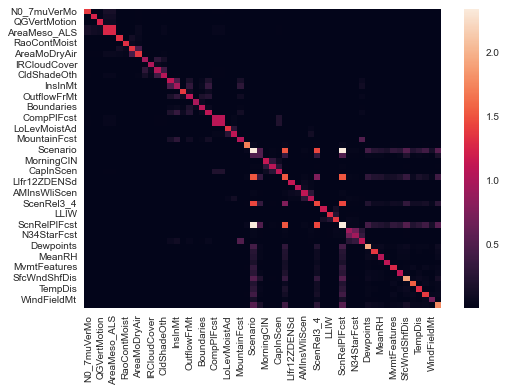

In [81]:
sns.heatmap(df_distance)

In [82]:
#corr = df_coded.corr(method='spearman')
#sns.heatmap(corr)

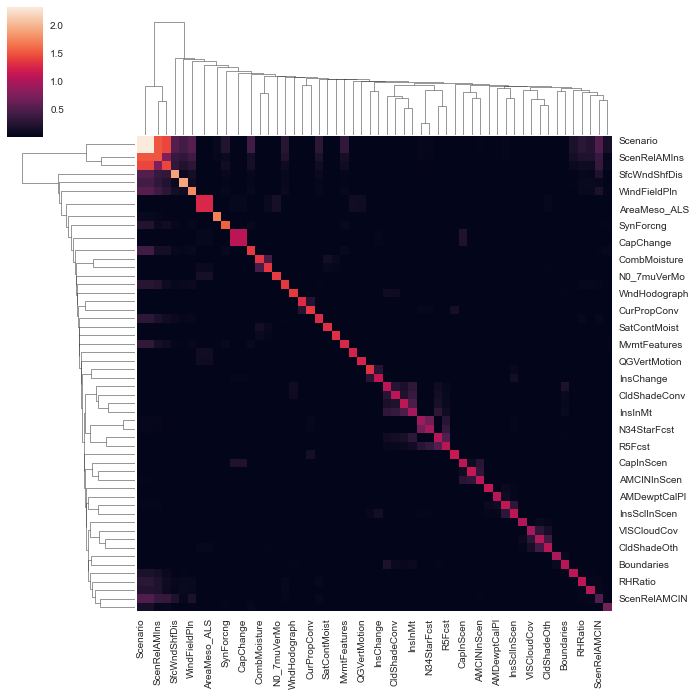

In [83]:
sns.clustermap(df_distance)

In [84]:
clustering = AgglomerativeClustering(n_clusters=5,affinity='precomputed', linkage = 'complete').fit(df_distance.values)

In [85]:
df_distance['label'] = clustering.labels_

In [86]:
for i in range(5):
    sub_df = df_distance.loc[df_distance['label'] == i]
    print(sub_df.shape[0])

18
12
1
1
24


In [87]:
structure = pd.read_csv('C:\\Users\\Jerzy\\Documents\\GitHub\\BAMT\\data\\hailfinder_structure.csv')
structure

,arcs.from,arcs.to
0,N07muVerMo,CombVerMo
1,SubjVertMo,CombVerMo
2,QGVertMotion,CombVerMo
3,SatContMoist,CombMoisture
4,RaoContMoist,CombMoisture
...,...,...
61,N34StarFcst,R5Fcst
62,CapInScen,PlainsFcst
63,InsSclInScen,PlainsFcst
64,CurPropConv,PlainsFcst


In [88]:
structure_right = []
for i in structure.index:
    structure_right.append([structure.loc[i,'arcs.from'], structure.loc[i,'arcs.to']])

In [89]:
groups = get_n_nearest(df_distance, df.columns.tolist(), corr = True)

In [90]:
brave = pd.DataFrame(data=np.zeros((len(df.columns), len(df.columns))), columns=df.columns)
brave.index = df.columns

In [91]:
for c1 in df.columns:
    for c2 in df.columns:
        a = 0
        b = 0
        c = 0
        d = 0
        if c1 != c2:
            for g in groups:
                if (c1 in g) & (c2 in g):
                    a += 1
                if (c1 in g) & (c2 not in g):
                    b += 1
                if (c1 not in g) & (c2 in g):
                    c += 1
                if (c1 not in g) & (c2 not in g):
                    d += 1
            br = (a*len(groups) + (a+c)*(a+b)) / ((math.sqrt((a + c + 0.00000001)*(b+d + 0.00000001))) * (math.sqrt((a+b + 0.00000001)*(c+d + 0.00000001))))
            brave.loc[c1,c2] = br




<AxesSubplot:>

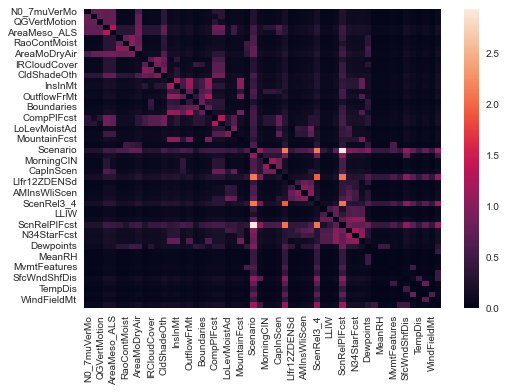

In [92]:
sns.heatmap(brave)

100%|██████████| 44/44 [00:47<00:00,  1.07s/it]


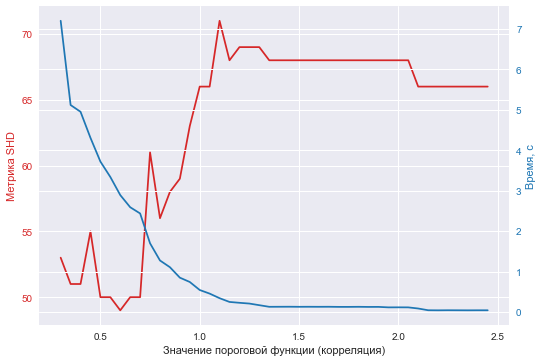

In [93]:
shd_results = []
range_of_experiment = []
time_not_norm = []
range_of_experiment = np.arange(0.3, 2.5, 0.05)
for n in tqdm(range_of_experiment):
    possible_edges = []
    for c1 in df.columns:
        for c2 in df.columns:
            if brave.loc[c1, c2] > n:
                possible_edges.append((c1, c2))
    start_time = time.time()
    bn = structure_learning(df_coded, 'HC', get_nodes_type(df), 'K2', white_list=possible_edges)
    time_not_norm.append(time.time() - start_time)
    brave_edgse = []
    for e in bn['E']:
        brave_edgse.append((e[0], e[1]))
    shd_results.append(precision_recall(brave_edgse, structure_right)['SHD'])
shd_results 

plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Значение пороговой функции (корреляция)')
ax1.set_ylabel('Метрика SHD', color=color)
ax1.plot(range_of_experiment, shd_results, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Время, с', color=color)  
ax2.plot(range_of_experiment, time_not_norm, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()




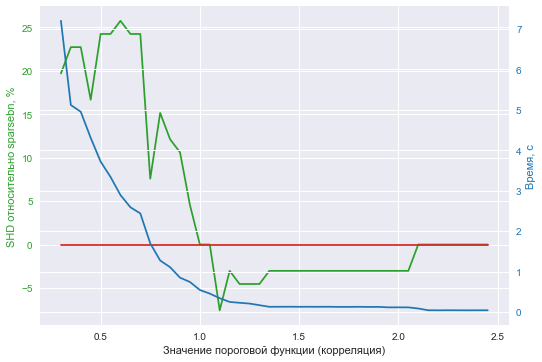

In [103]:
shd_results_relative = (1 - np.asarray(shd_results)/66) * 100
fig, ax1 = plt.subplots()
color = 'tab:green'
ax1.set_xlabel('Значение пороговой функции (корреляция)')
ax1.set_ylabel('SHD относительно sparsebn, %', color=color)
ax1.plot(range_of_experiment, shd_results_relative, color=color)
ax1.plot(range_of_experiment, shd_results_relative*0, color='tab:red')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Время, с', color=color)  
ax2.plot(range_of_experiment, time_not_norm, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()

In [95]:
possible_edges = []
for c1 in df.columns:
    for c2 in df.columns:
        if brave.loc[c1, c2] > 1.2:
            possible_edges.append((c1, c2))


In [96]:
bn = 0
bn = structure_learning(df_coded, 'HC', get_nodes_type(df), 'K2', white_list=possible_edges)
brave_edgse = []
for e in bn['E']:
    brave_edgse.append((e[0], e[1]))

brave_edgse

[('CombVerMo', 'AreaMeso_ALS'),
 ('InsInMt', 'AMInstabMt'),
 ('OutflowFrMt', 'CldShadeConv'),
 ('CapChange', 'CompPlFcst'),
 ('ScenRelAMIns', 'ScnRelPlFcst'),
 ('ScnRelPlFcst', 'Scenario'),
 ('ScnRelPlFcst', 'ScenRel3_4'),
 ('PlainsFcst', 'N34StarFcst')]

In [97]:
precision_recall(brave_edgse, structure_right)

{'AP': 0.5, 'AR': 0.06, 'AHP': 0.12, 'AHR': 0.02, 'SHD': 69}

100%|██████████| 22/22 [03:59<00:00, 10.88s/it]


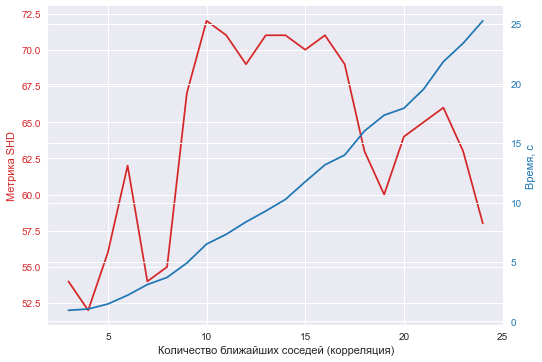

In [98]:
shd_different_n_nearest = []
time_n_nearest = []
range_of_n_nearest = np.arange(3, 25)
brave = pd.DataFrame(data=np.zeros((len(df.columns), len(df.columns))), columns=df.columns)
brave.index = df.columns
for i in tqdm(range_of_n_nearest):
    start_time = time.time()
    groups = get_n_nearest(df_distance, df.columns.tolist(), corr=True, number_close= i)
    for c1 in df.columns:
        for c2 in df.columns:
            a = 0
            b = 0
            c = 0
            d = 0
            if c1 != c2:
                for g in groups:
                    if (c1 in g) & (c2 in g):
                        a += 1
                    if (c1 in g) & (c2 not in g):
                        b += 1
                    if (c1 not in g) & (c2 in g):
                        c += 1
                    if (c1 not in g) & (c2 not in g):
                        d += 1
                br = (a*len(groups) + (a+c)*(a+b)) / ((math.sqrt((a + c + 0.00000001)*(b+d + 0.00000001))) * (math.sqrt((a+b + 0.00000001)*(c+d + 0.00000001))))
                brave.loc[c1,c2] = br
    possible_edges = []
    for c1 in df.columns:
        for c2 in df.columns:
            if brave.loc[c1, c2] > 0.8:
                possible_edges.append((c1, c2))
    bn = structure_learning(df_coded, 'HC', get_nodes_type(df), 'K2', white_list=possible_edges)
    brave_edgse = []
    for e in bn['E']:
        brave_edgse.append((e[0], e[1]))
    shd_different_n_nearest.append(precision_recall(brave_edgse, structure_right)['SHD'])
    time_n_nearest.append(time.time() - start_time)
shd_different_n_nearest

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Количество ближайших соседей (корреляция)')
ax1.set_ylabel('Метрика SHD', color=color)
ax1.plot(range_of_n_nearest, shd_different_n_nearest, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Время, с', color=color)  
ax2.plot(range_of_n_nearest, time_n_nearest, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()



No handles with labels found to put in legend.


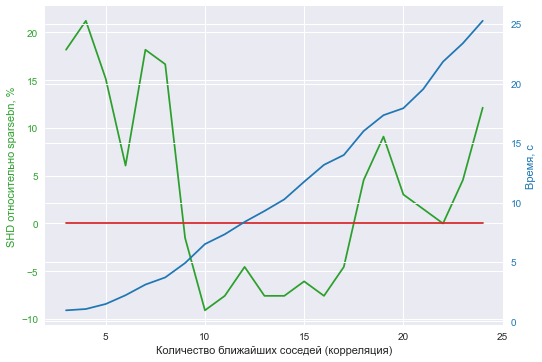

In [102]:
shd_results_n_relative = (1 - np.asarray(shd_different_n_nearest)/66) * 100
fig, ax1 = plt.subplots()
color = 'tab:green'
ax1.set_xlabel('Количество ближайших соседей (корреляция)')
ax1.set_ylabel('SHD относительно sparsebn, %', color=color)
ax1.plot(range_of_n_nearest, shd_results_n_relative, color=color, label = 'Относительная SHD')
ax1.plot(range_of_n_nearest, 0*shd_results_n_relative, color='tab:red', label = 'SHD sparsebn')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Время, с', color=color)  
ax2.plot(range_of_n_nearest, time_n_nearest, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()